In [13]:
# Standard library imports
from datetime import time, datetime, timedelta
import os

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from tqdm import tqdm
from joblib import Parallel, delayed

# Local imports
from helper_code import *
from team_code import *
from segment_quality_evaluation import process_EEG

from FMMFeatureExtractor import FMMFeatureExtractor
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from helper_code import load_recording_data

import wandb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import matplotlib as mpl

mpl.rcParams["axes.labelweight"] = "bold"

# autoreload changes in helper_code and team_code
%load_ext autoreload
%autoreload 2


# Get the start time (as a time object) from the recording data.
def get_start_time_triplet(string):
    variable = get_variable(string, '#Start time', str)
    hours, minutes, seconds = (int(value) for value in variable.split(':'))
    return time(hours, minutes, seconds)

# Get the end time (as a time object) from the recording data.
def get_end_time_triplet(string):
    variable = get_variable(string, '#End time', str)
    hours, minutes, seconds = (int(value) for value in variable.split(':'))
    return time(hours, minutes, seconds)

DATA_FOLDER = "../data/"
ROOT_FOLDER = DATA_FOLDER+ "physionet.org/files/i-care/2.1/training"
TRAIN_HOSPITALS = ['A', 'B', 'E']
TEST_HOSPITALS = ['D', 'F']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def segmentos_5_minutos(start: time, end: time):
    # Convertir a datetime para facilitar los cálculos
    start_dt = datetime(2000, 1, 1, start.hour, start.minute, start.second)
    end_dt = datetime(2000, 1, 1, end.hour, end.minute, end.second)
    
    # Ajustar el inicio al siguiente múltiplo de 5 minutos
    start_min = (start_dt.minute // 5) * 5
    if start_dt.minute % 5 != 0 or start_dt.second > 0:
        start_min += 5
    
    # Controlar si start_min se vuelve 60 y ajustar la hora
    if start_min == 60:
        start_segment = datetime(2000, 1, 1, start_dt.hour + 1, 0, 0)
    else:
        start_segment = datetime(2000, 1, 1, start_dt.hour, start_min, 0)
    
    # Lista de segmentos
    segments = []
    
    while start_segment + timedelta(minutes=5) - timedelta(seconds=1) <= end_dt:
        end_minute = start_segment.minute + 4
        end_hour = start_segment.hour
        if end_minute >= 60:
            end_minute -= 60
            end_hour += 1
        
        segments.append((
            time(start_segment.hour, start_segment.minute, 0),
            time(end_hour, end_minute, 59)
        ))
        start_segment += timedelta(minutes=5)
    
    return segments

def dividir_dataframe_en_segmentos(df, start: time, end: time, sampling_frequency: int):
    samples_per_5_min = sampling_frequency * 5 * 60
    start_times = []
    end_times = []

    # If len is less that 5min do early return
    if len(df) < samples_per_5_min:
        return start_times, end_times

    segments = segmentos_5_minutos(start, end)

    return segments

In [4]:
# Definir los tiempos de inicio y fin
start_time = time(23, 00, 0)
end_time = time(23, 59, 59)

# Crear un DataFrame de ejemplo con sampling_frequency de 128
sampling_frequency = 128  # 128 observaciones por segundo
total_seconds = (datetime(2000, 1, 1, end_time.hour, end_time.minute, end_time.second) - 
                 datetime(2000, 1, 1, start_time.hour, start_time.minute, start_time.second)).total_seconds()
data = {"col1": range(int(total_seconds * sampling_frequency)), "col2": range(int(total_seconds * sampling_frequency))}
df = pd.DataFrame(data)

# Obtener sub DataFrames
segments = dividir_dataframe_en_segmentos(df, start_time, end_time, sampling_frequency)

# Imprimir cada sub DataFrame
for i, (start_frag, end_frag) in enumerate(segments):
    print(f"Segmento {i + 1} (Inicio: {start_frag}, Fin: {end_frag}):")

Segmento 1 (Inicio: 23:00:00, Fin: 23:04:59):
Segmento 2 (Inicio: 23:05:00, Fin: 23:09:59):
Segmento 3 (Inicio: 23:10:00, Fin: 23:14:59):
Segmento 4 (Inicio: 23:15:00, Fin: 23:19:59):
Segmento 5 (Inicio: 23:20:00, Fin: 23:24:59):
Segmento 6 (Inicio: 23:25:00, Fin: 23:29:59):
Segmento 7 (Inicio: 23:30:00, Fin: 23:34:59):
Segmento 8 (Inicio: 23:35:00, Fin: 23:39:59):
Segmento 9 (Inicio: 23:40:00, Fin: 23:44:59):
Segmento 10 (Inicio: 23:45:00, Fin: 23:49:59):
Segmento 11 (Inicio: 23:50:00, Fin: 23:54:59):
Segmento 12 (Inicio: 23:55:00, Fin: 23:59:59):


In [5]:
data_folder = ROOT_FOLDER
patient_ids = find_data_folders(data_folder)
num_patients = len(patient_ids)
current_features = None
GROUP = 'EEG'

def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def resample_segment(data, original_sampling_frequency, target_sampling_frequency):
    num_samples = int(data.shape[1] * target_sampling_frequency / original_sampling_frequency)
    resampled_data = resample(data, num_samples, axis=1)
    return resampled_data

In [6]:
N_HOURS = 12

MIN_MINUTES = 5
DROP_MEAN_STD = 0
DOUBLE_BANANA = [
        ("Fp1", "F7"), ("F7", "T3"), ("T3", "T5"), ("T5", "O1"),  # Left temporal chain
        ("Fp2", "F8"), ("F8", "T4"), ("T4", "T6"), ("T6", "O2"),  # Right temporal chain
        ("Fp1", "F3"), ("F3", "C3"), ("C3", "P3"), ("P3", "O1"),  # Left parasagittal chain
        ("Fp2", "F4"), ("F4", "C4"), ("C4", "P4"), ("P4", "O2"),  # Right parasagittal chain
        ("Fz", "Cz"), ("Cz", "Pz")                                # Central chain
]
BANDPASS_FREQS = [0.1, 45.0]
TARGET_SAMPLING_FREQUENCY = 128 # Nyquist

In [7]:
len(DOUBLE_BANANA)

18

In [8]:
rec_loc = "../data/physionet.org/files/i-care/2.1/training/0284/0284_010_012_EEG"
# read a eeg file
data, channels, sampling_frequency = load_recording_data(rec_loc)
utility_frequency = get_utility_frequency(rec_loc + ".hea")
data, sampling_frequency = preprocess_data(
            data, sampling_frequency, utility_frequency, channels
        )
data = get_bipolar_data(data)  # Create double-banana montage
data.shape

(57344, 18)

## FMM features

(73954, 9)


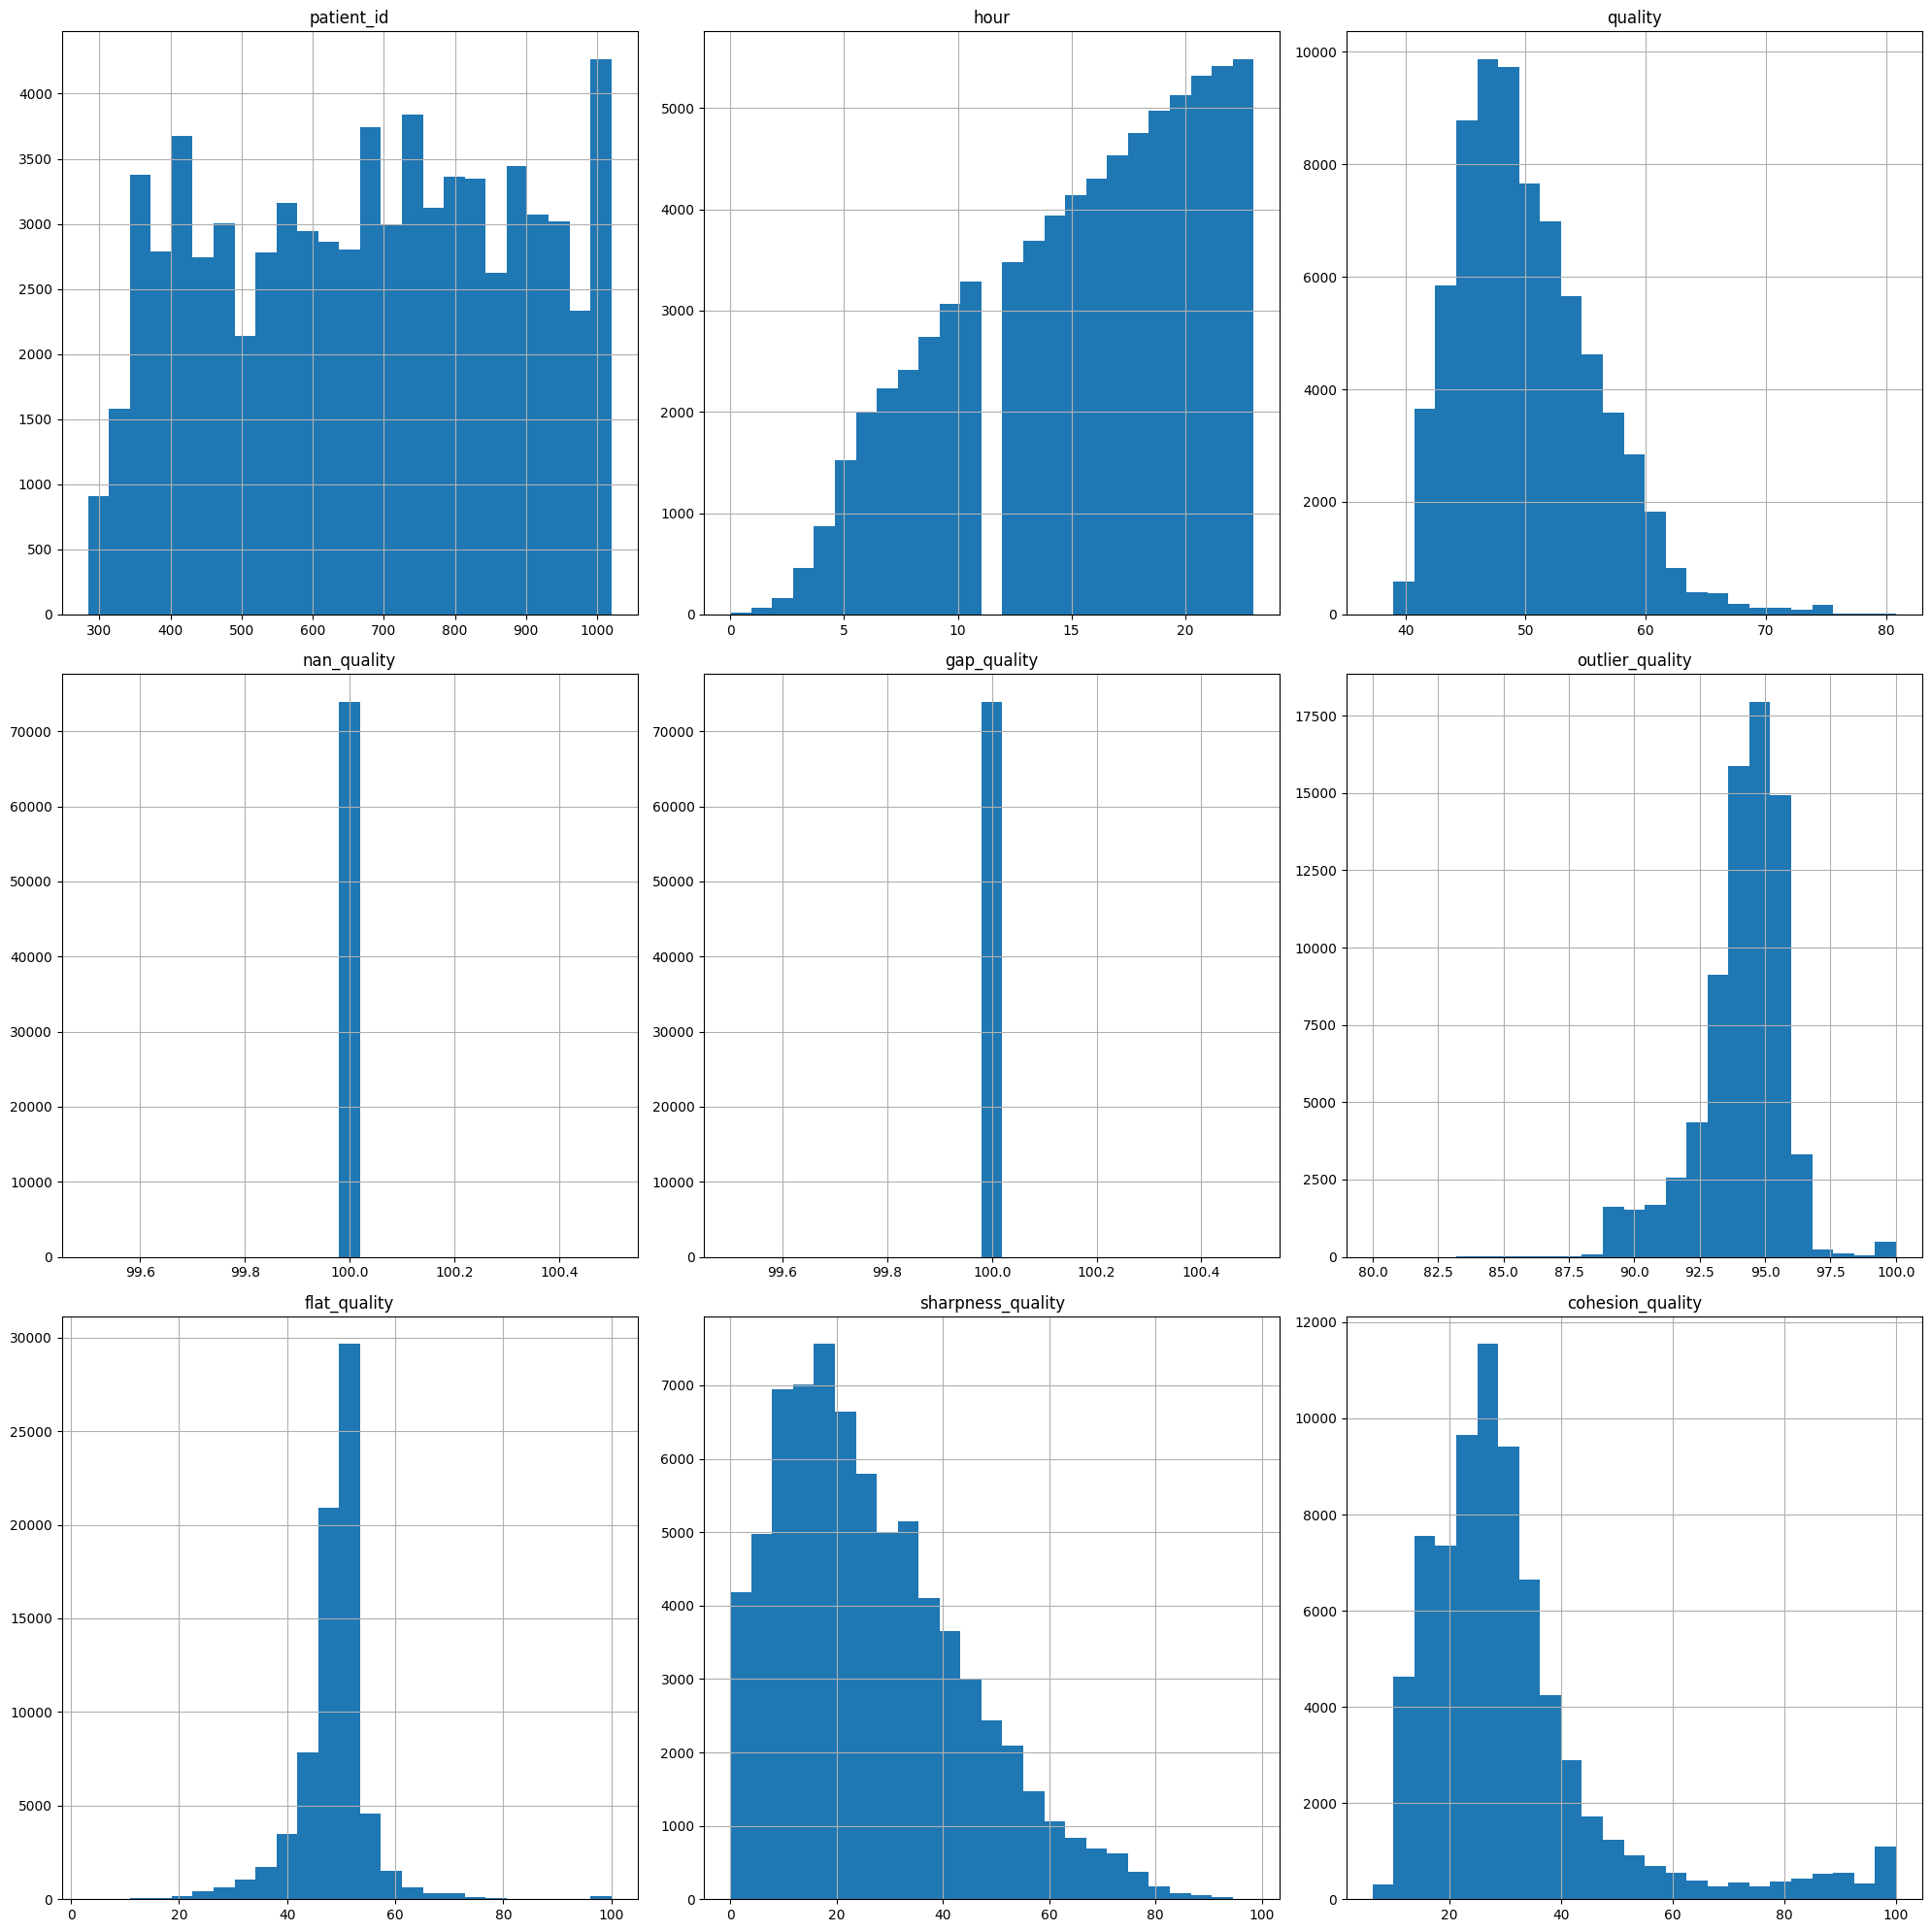

In [9]:
# read all excel files in the folder and concatenate them into a single dataframe
quality_folder = os.path.join(DATA_FOLDER, "quality")
quality_files = [f for f in os.listdir(quality_folder) if f.endswith(".csv")]
quality_dfs = [pd.read_csv(os.path.join(quality_folder, f)) for f in quality_files]
quality_df = pd.concat(quality_dfs, axis=0)
print(quality_df.shape)
quality_df.insert(1, "hour", quality_df["start_time"].apply(lambda x: int(x.split(":")[0])))
quality_df.insert(2, "time_block", quality_df["hour"].floordiv(4).apply(lambda x: f"{x*4}-{(x+1)*4}H"))
# SHIFT = 0
# quality_df["outlier_quality"] = (100 / (100 - SHIFT)) * (quality_df["outlier_quality"] - SHIFT)
# quality_df["outlier_quality"] = quality_df["outlier_quality"].clip(0, 100)  # Clip to range [0, 100]

quality = quality_df.iloc[:, -4:].mean(axis=1)
quality_df.insert(4, "quality", quality)
quality_df = quality_df.sort_values(by=["patient_id", "start_time"], ascending=True)
quality_df.head()
# plot the distribution of each quality metric
quality_df.hist(figsize=(20, 20), bins=25)
plt.tight_layout()
plt.show()


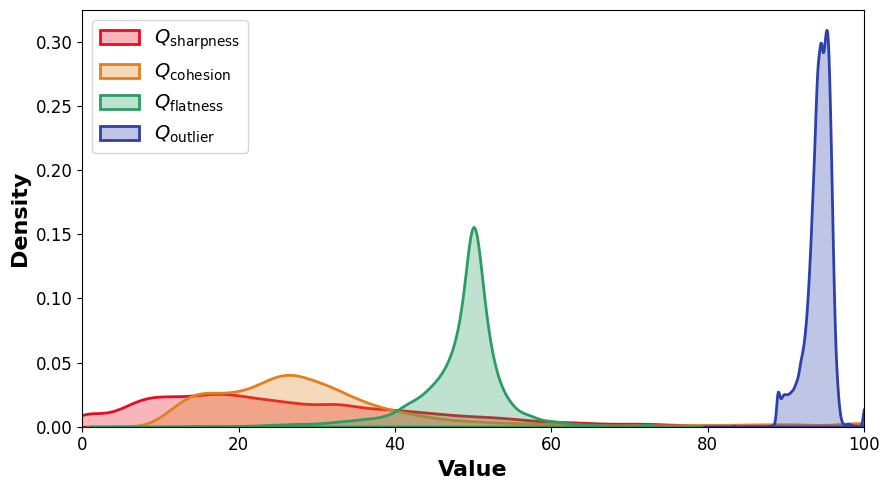

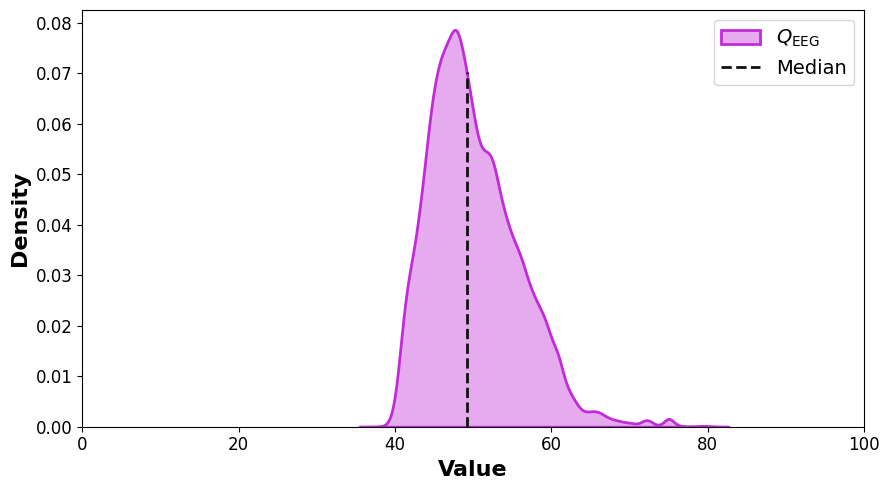

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Tamaños de fuente
LEGEND_FONT_SIZE = 14
TICK_FONT_SIZE = 12
LABEL_FONT_SIZE = 16
TITLE_FONT_SIZE = 18

# Paleta de colores moderna y diferenciada
palette_vars = {
    'outlier_quality': "#2e40aa",  
    'flat_quality': "#2a9d64",     
    'sharpness_quality': "#e70d1f",
    'cohesion_quality': "#e3801d", 
    'quality': "#c12cd8"           # morado
}

# Diccionario para los nombres en LaTeX
latex_labels = {
    'outlier_quality': r'$Q_{\text{outlier}}$',
    'flat_quality': r'$Q_{\text{flatness}}$',
    'sharpness_quality': r'$Q_{\text{sharpness}}$',
    'cohesion_quality': r'$Q_{\text{cohesion}}$',
    'quality': r'$Q_{\text{EEG}}$'
}

# ================================
# 📌 PRIMER PLOT: DISTRIBUCIONES INDIVIDUALES
# ================================
fig, ax = plt.subplots(figsize=(9, 5))

for var in ['sharpness_quality', 'cohesion_quality', 'flat_quality', 'outlier_quality']:
    sns.kdeplot(
        data=quality_df, 
        x=var, 
        fill=True, 
        common_norm=False, 
        color=palette_vars[var],
        label=latex_labels[var], 
        alpha=0.3, 
        linewidth=2, 
        gridsize=500,
        ax=ax
    )

# Configuración de labels y estilo
ax.set_xlabel("Value", fontsize=LABEL_FONT_SIZE)
ax.set_ylabel("Density", fontsize=LABEL_FONT_SIZE)
ax.tick_params(axis='both', labelsize=TICK_FONT_SIZE)
ax.legend(title=None, fontsize=LEGEND_FONT_SIZE)
ax.set_xlim(0, 100)
plt.tight_layout()
plt.savefig("../img/quality_distributions.png", dpi=300)
plt.show()

# ================================
# 📌 SEGUNDO PLOT: DISTRIBUCIÓN DE Q_{EEG}
# ================================
fig, ax = plt.subplots(figsize=(9, 5))

# Densidad de Q_{EEG}
sns.kdeplot(
    data=quality_df,
    x='quality',
    fill=True,
    color=palette_vars['quality'],
    alpha=0.4,
    linewidth=2,
    gridsize=500,
    ax=ax,
    label=latex_labels['quality']
)

# Mediana de quality
median_quality = quality_df['quality'].median()
kde = gaussian_kde(quality_df['quality'], bw_method='scott')
density_at_median = kde.evaluate(median_quality)[0]

# Línea de la mediana con label
ax.axvline(
    median_quality, 
    linestyle='--', 
    color="#111111", 
    ymax=density_at_median/ax.get_ylim()[1], 
    linewidth=2,
    label='Median'
)

# Configuración de labels y estilo
ax.set_xlabel(f"Value", fontsize=LABEL_FONT_SIZE)
ax.set_xlim(0, 100)
ax.set_ylabel("Density", fontsize=LABEL_FONT_SIZE)
ax.tick_params(axis='both', labelsize=TICK_FONT_SIZE)
ax.legend(title=None, fontsize=LEGEND_FONT_SIZE)
plt.tight_layout()
plt.savefig("../img/quality.png", dpi=300)
plt.show()


## Classification

In [19]:
features_folder = os.path.join(DATA_FOLDER, "features_classical")
features_files = [f for f in os.listdir(features_folder) if f.endswith(".csv")]
features_dfs = [pd.read_csv(os.path.join(features_folder, f), dtype={"patient_id": str}) for f in features_files]
df_features_classical = pd.concat(features_dfs, axis=0)
# sort by patient_id and start_time
df_features_classical = df_features_classical.sort_values(by=["patient_id", "start_time"], ascending=True)
df_features_classical.insert(1, "hour", df_features_classical["start_time"].str.split(":").str[0].astype(int))
print(df_features_classical.shape)

(232170, 225)


In [20]:
features_folder = os.path.join(DATA_FOLDER, "features_fmm")
features_files = [f for f in os.listdir(features_folder) if f.endswith(".csv")]
features_dfs = [pd.read_csv(os.path.join(features_folder, f), dtype={"patient_id": str}) for f in features_files]
df_features_fmm = pd.concat(features_dfs, axis=0)

# # sort by patient_id and start_time
df_features_fmm = df_features_fmm.sort_values(by=["patient_id", "start_time"], ascending=True)
df_features_fmm.insert(1, "hour", df_features_fmm["start_time"].str.split(":").str[0].astype(int))
print(df_features_fmm.shape)

(2321700, 27)


In [21]:
df_features_fmm

,patient_id,hour,start_time,end_time,epoch_num,Wave,FMM_R2,FMM_α,FMM_ω,FMM_A_Fp1-F7,...,FMM_A_Fp1-F3,FMM_A_F3-C3,FMM_A_C3-P3,FMM_A_P3-O1,FMM_A_Fp2-F4,FMM_A_F4-C4,FMM_A_C4-P4,FMM_A_P4-O2,FMM_A_Fz-Cz,FMM_A_Cz-Pz
0,0284,4,04:10:00,04:14:59,1,1,3.108366e-02,2.179480,0.177998,0.275150,...,0.218216,0.082313,0.148656,0.138508,0.127272,0.318660,0.300175,0.062722,0.209602,0.096955
1,0284,4,04:10:00,04:14:59,1,2,9.017758e-03,3.136684,0.005025,0.356182,...,0.312466,0.337648,0.113194,0.145477,0.161724,0.383310,0.561932,0.706814,0.162268,0.216783
2,0284,4,04:10:00,04:14:59,1,3,5.196736e-02,3.141593,0.055708,0.186716,...,0.123534,0.251096,0.096275,0.108886,0.105663,0.335136,0.409742,0.444534,0.196126,0.199637
3,0284,4,04:10:00,04:14:59,1,4,3.832494e-02,4.447317,0.105724,0.860693,...,0.599889,0.268582,0.081395,0.458601,0.346356,0.248414,0.844688,0.886178,0.493357,0.893018
4,0284,4,04:10:00,04:14:59,1,5,3.380823e-02,4.746750,0.078297,1.651036,...,1.405545,0.714867,0.633151,1.144691,0.959235,0.650289,0.602379,0.955106,0.425399,0.589085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,1020,23,23:15:00,23:19:59,30,6,-1.340595e-16,1.757328,0.005025,0.350598,...,0.634891,0.145640,0.194093,1.973312,0.880356,5.295359,5.298604,1.044659,0.299534,0.788980
2396,1020,23,23:15:00,23:19:59,30,7,3.477139e-03,1.772055,0.005025,0.112549,...,0.146765,0.125770,0.349323,1.268591,0.486586,2.199410,2.122293,0.428088,0.084912,0.287786
2397,1020,23,23:15:00,23:19:59,30,8,2.863961e-03,1.781872,0.005025,0.059734,...,0.033720,0.098102,0.209123,0.621754,0.264749,1.865901,1.860319,0.194721,0.040289,0.111559
2398,1020,23,23:15:00,23:19:59,30,9,9.522019e-02,3.372303,0.121455,0.025458,...,0.049557,0.030936,0.033948,0.184189,0.015669,0.043892,0.100676,0.072696,0.012639,0.016513


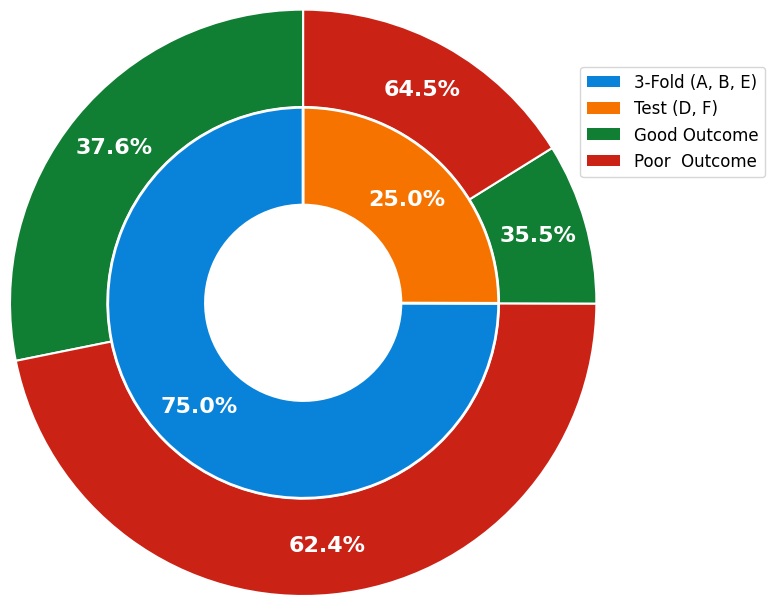

In [15]:

HOSPITAL_ORDER = ['A', 'B', 'E', 'D', 'F']

MIDDLE_LABELS = ['3-Fold (A, B, E)', 'Test (D, F)']
MIDDLE_COLORS = ["#0983da", "#f77300"]
OUTCOME_0 = "#107e33"
OUTCOME_1 = "#cb2216"
OUTER_COLORS = [OUTCOME_0, OUTCOME_1 , OUTCOME_0, OUTCOME_1]

WIDTH = 0.5  # grosor anillos
FIGSIZE = (8, 8)

# Datos
X_clinical = pd.read_csv(DATA_FOLDER + "X_clinical.csv", dtype={"patient_id": str})
hospital_counts = X_clinical['hospital'].value_counts().reindex(HOSPITAL_ORDER).fillna(0)
train_count = X_clinical[X_clinical['hospital'].isin(TRAIN_HOSPITALS)].shape[0]
test_count = X_clinical[X_clinical['hospital'].isin(TEST_HOSPITALS)].shape[0]

middle_sizes = [train_count, test_count]

def count_outcome(hosp_list, outcome_val):
    return X_clinical[(X_clinical['hospital'].isin(hosp_list)) & (X_clinical['outcome'] == outcome_val)].shape[0]

outer_sizes = [
    count_outcome(TRAIN_HOSPITALS, 0),
    count_outcome(TRAIN_HOSPITALS, 1),
    count_outcome(TEST_HOSPITALS, 0),
    count_outcome(TEST_HOSPITALS, 1),
]

total = sum(outer_sizes)

total_train = sum(outer_sizes[:2])
total_test = sum(outer_sizes[2:])

outer_sizes_norm = [x / total for x in outer_sizes]
middle_sizes_norm = [x / total for x in middle_sizes]

fig, ax = plt.subplots(figsize=FIGSIZE)

wedges_outer, _ = ax.pie(
    outer_sizes_norm,
    radius=1.5,
    colors=OUTER_COLORS,
    wedgeprops=dict(width=WIDTH, edgecolor='w', linewidth=1.5),
    startangle=90,
    labels=[None]*4
)

wedges_middle, _ = ax.pie(
    middle_sizes_norm,
    radius=1.0,
    colors=MIDDLE_COLORS,
    wedgeprops=dict(width=WIDTH, edgecolor='w', linewidth=2),
    startangle=90,
    labels=[None]*2,
)

# Redefine for labels
outer_sizes_norm = [outer_sizes[0]/total_train, outer_sizes[1]/total_train,
                    outer_sizes[2]/total_test, outer_sizes[3]/total_test]
middle_sizes_norm = [x / total for x in middle_sizes]

def put_percentage_text(wedges, sizes, outer_radius, width):
    radius_center = outer_radius - width / 2
    for wedge, size in zip(wedges, sizes):
        angle = (wedge.theta2 + wedge.theta1) / 2
        x = radius_center * np.cos(np.deg2rad(angle))
        y = radius_center * np.sin(np.deg2rad(angle))
        pct = f"{size*100:.1f}%"
        ax.text(x, y, pct, ha='center', va='center', fontsize=16, color='white', fontweight='bold')

put_percentage_text(wedges_outer, outer_sizes_norm, 1.5, WIDTH)
put_percentage_text(wedges_middle, middle_sizes_norm, 1.0, WIDTH)

legend_elements = []

for label, color in zip(MIDDLE_LABELS, MIDDLE_COLORS):
    legend_elements.append(Patch(facecolor=color, label=label))

legend_elements.append(Patch(facecolor=OUTCOME_0, label='Good Outcome'))
legend_elements.append(Patch(facecolor=OUTCOME_1, label='Poor  Outcome'))

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), fontsize=12)
plt.tight_layout()
plt.savefig("../img/validation_distr.png", dpi=300, bbox_inches='tight')
plt.show()


In [16]:

def prepare_datasets(
    X_clinical: pd.DataFrame,
    df_features_classical: pd.DataFrame,
    df_features_fmm: pd.DataFrame,
    epoch_subset: pd.DataFrame,
    filter_column: str,
    test_hospitals: list = TEST_HOSPITALS
):
    COLS2DROP = ["outcome", "patient_id", "hospital", "outcome", "cpcs"]

    X = X_clinical.copy()

    n_total = X_clinical["patient_id"].nunique()
    n_withdata = df_features_fmm["patient_id"].nunique()
    discard_perc = (n_total - n_withdata) / n_total * 100
    #print(f"{n_total - n_withdata=}")

    ### Filtrar por epoch_subset (solo filas donde `filter_column` sea True)
    key_cols = ["patient_id", "start_time"]
    filtered_epochs = epoch_subset[key_cols]
    filtered_epochs = filtered_epochs[epoch_subset[filter_column] == True]
    


    # Merge de classical features
    subdf_classical = df_features_classical[df_features_classical["hour"] < 24]
    
    subdf_classical = pd.merge(
        df_features_classical, filtered_epochs, on=key_cols, how="inner"
    )

    subdf_classical = subdf_classical.drop(columns=["hour", "start_time", "end_time", "epoch_num"], errors='ignore')
    #print(f"Classical Epoch Features shape: {subdf_classical.shape}")
    subdf_classical = subdf_classical.groupby("patient_id").median().reset_index()
    X = pd.merge(X, subdf_classical, on="patient_id", how="right")

    # Merge de FMM features
    subdf_fmm = df_features_fmm[df_features_fmm["hour"] < 24]
    subdf_fmm = pd.merge(
        df_features_fmm, filtered_epochs, on=key_cols, how="inner"
    )

    subdf_fmm = subdf_fmm.drop(columns=["hour", "start_time", "end_time", "epoch_num"], errors='ignore')
    #print(f"FMM Epoch Features shape: {subdf_fmm.shape}")
    subdf_fmm = subdf_fmm.groupby("patient_id").median().reset_index()
    X = pd.merge(X, subdf_fmm, on="patient_id", how="left")

    # Separar en train_val y test
    X_train_val = X[~X["hospital"].isin(test_hospitals)].copy()
    y_train_val = X_train_val["outcome"]
    groups_train_val = X_train_val["hospital"]
    X_train_val = X_train_val.drop(columns=COLS2DROP, errors='ignore')

    X_test = X[X["hospital"].isin(test_hospitals)].copy()
    y_test = X_test["outcome"]
    groups_test = X_test["hospital"]
    X_test = X_test.drop(columns=COLS2DROP, errors='ignore')

    return X_train_val, y_train_val, groups_train_val, X_test, y_test, groups_test


In [17]:
def cross_validate(X_train_val, y_train_val, groups_train_val, seed=42):
    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=len(groups_train_val.unique()))

    # Define preprocessing for numerical and categorical features
    numerical_features = X_train_val.select_dtypes(include=["float64", "int64"]).columns
    categorical_features = X_train_val.select_dtypes(include=["object"]).columns

    numerical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean")),  # Handle missing values
            # ('scaler', StandardScaler())                 # Scale numerical values
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),  # Handle missing values
            (
                "onehot",
                OneHotEncoder(handle_unknown="ignore"),
            ),  # One-hot encode categorical values
        ]
    )

    # Combine preprocessors in a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(random_state=seed)),
        ]
    )

    scores = cross_val_score(
        pipeline,
        X_train_val,
        y_train_val,
        groups=groups_train_val,
        cv=group_kfold,
        scoring="roc_auc",
        n_jobs=-1,
    )
    return scores

In [ ]:
X_train_val, y_train_val, groups_train_val, X_test, y_test, groups_test = (
            prepare_datasets(
                X_clinical,
                df_features_classical,
                df_features_fmm,
                epoch_subset,
                filter_column="lastQ50+",
            )
        )
pipeline.fit(X_train_val, y_train_val)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
print(f"Test ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

(40200, 225)
(402000, 27)
[LightGBM] [Info] Number of positive: 220, number of negative: 134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28586
[LightGBM] [Info] Number of data points in the train set: 354, number of used features: 248
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,621469 -> initscore=0,495788
[LightGBM] [Info] Start training from score 0,495788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [51]:
epoch_subset

,patient_id,hour,time_block,start_time,quality,end_time,nan_quality,gap_quality,outlier_quality,flat_quality,sharpness_quality,cohesion_quality,maxQ,minQ,random,middle,last,lastQ50+,all
0,0284,4.0,4-8H,04:10:00,57.375176,04:14:59,100.0,100.0,93.104890,47.725839,59.640442,29.029533,1.0,NaN,NaN,NaN,NaN,NaN,1
1,0284,NaN,NaN,04:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0284,NaN,NaN,04:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,0284,NaN,NaN,04:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,0284,NaN,NaN,04:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75529,1020,NaN,NaN,23:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
75530,1020,NaN,NaN,23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
75531,1020,NaN,NaN,23:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
75532,1020,NaN,NaN,23:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [54]:
strategies

Index(['maxQ', 'minQ', 'random', 'middle', 'last', 'lastQ50+', 'all'], dtype='object')

In [22]:
from xgboost import XGBClassifier

epoch_subset = pd.read_csv(
    os.path.join(DATA_FOLDER, "epoch_subset.csv"), dtype={"patient_id": "object"}
)
strategies = epoch_subset.columns[12:]
results = {x: [] for x in strategies}


SEEDS = [42, 14, 301, 104, 213, 639, 899, 530, 569, 124, 178, 147, 948, 806, 34, 867, 
         76, 590, 462, 465, 754, 886, 477, 4039, 3280, 1225, 296, 3430, 2893, 4346]

for seed in tqdm(SEEDS, desc="Running seeds"):
    for filter_column in strategies:
        # print(f"Seed {seed} Processing filter column: {filter_column}")
        X_train_val, y_train_val, groups_train_val, X_test, y_test, groups_test = (
            prepare_datasets(
                X_clinical,
                df_features_classical,
                df_features_fmm,
                epoch_subset,
                filter_column=filter_column,
            )
        )
        scores = cross_validate(X_train_val, y_train_val, groups_train_val, seed=seed)
        score = round(np.mean(scores), 3)
        print(seed, filter_column, score)
        results[filter_column].append(score)

pd.DataFrame(results).to_csv(os.path.join(DATA_FOLDER, "quality_strategies.csv"), index=False)

Running seeds:   0%|          | 0/30 [00:00<?, ?it/s]

42 maxQ 0.681
42 minQ 0.614
42 random 0.696
42 central 0.688
42 last 0.661
42 lastQ50+ 0.735


Running seeds:   3%|▎         | 1/30 [00:17<08:37, 17.84s/it]

42 all 0.67
14 maxQ 0.673
14 minQ 0.625
14 random 0.697
14 central 0.679
14 last 0.67
14 lastQ50+ 0.735


Running seeds:   7%|▋         | 2/30 [00:29<06:45, 14.48s/it]

14 all 0.657
301 maxQ 0.692
301 minQ 0.635
301 random 0.677
301 central 0.664
301 last 0.668
301 lastQ50+ 0.75


Running seeds:  10%|█         | 3/30 [00:41<05:55, 13.17s/it]

301 all 0.666
104 maxQ 0.68
104 minQ 0.633
104 random 0.694
104 central 0.672
104 last 0.661
104 lastQ50+ 0.722


Running seeds:  13%|█▎        | 4/30 [00:53<05:29, 12.67s/it]

104 all 0.67
213 maxQ 0.662
213 minQ 0.602
213 random 0.678
213 central 0.676
213 last 0.668
213 lastQ50+ 0.73


Running seeds:  17%|█▋        | 5/30 [01:05<05:09, 12.38s/it]

213 all 0.666
639 maxQ 0.684
639 minQ 0.591
639 random 0.672
639 central 0.641
639 last 0.678
639 lastQ50+ 0.727


Running seeds:  20%|██        | 6/30 [01:17<04:52, 12.20s/it]

639 all 0.672
899 maxQ 0.687
899 minQ 0.598
899 random 0.658
899 central 0.679
899 last 0.639
899 lastQ50+ 0.721


Running seeds:  23%|██▎       | 7/30 [01:29<04:38, 12.13s/it]

899 all 0.661
530 maxQ 0.677
530 minQ 0.61
530 random 0.708
530 central 0.65
530 last 0.679
530 lastQ50+ 0.743


Running seeds:  27%|██▋       | 8/30 [01:40<04:23, 11.96s/it]

530 all 0.669
569 maxQ 0.678
569 minQ 0.596
569 random 0.686
569 central 0.647
569 last 0.665
569 lastQ50+ 0.728


Running seeds:  30%|███       | 9/30 [01:52<04:08, 11.85s/it]

569 all 0.661
124 maxQ 0.685
124 minQ 0.621
124 random 0.684
124 central 0.669
124 last 0.662
124 lastQ50+ 0.74


Running seeds:  33%|███▎      | 10/30 [02:03<03:55, 11.76s/it]

124 all 0.688
178 maxQ 0.651
178 minQ 0.624
178 random 0.691
178 central 0.66
178 last 0.688
178 lastQ50+ 0.723


Running seeds:  37%|███▋      | 11/30 [02:16<03:45, 11.88s/it]

178 all 0.675
147 maxQ 0.694
147 minQ 0.625
147 random 0.688
147 central 0.675
147 last 0.649
147 lastQ50+ 0.729


Running seeds:  40%|████      | 12/30 [02:28<03:34, 11.90s/it]

147 all 0.682
948 maxQ 0.672
948 minQ 0.616
948 random 0.688
948 central 0.671
948 last 0.655
948 lastQ50+ 0.723


Running seeds:  43%|████▎     | 13/30 [02:40<03:25, 12.07s/it]

948 all 0.667
806 maxQ 0.693
806 minQ 0.608
806 random 0.68
806 central 0.674
806 last 0.669
806 lastQ50+ 0.72


Running seeds:  47%|████▋     | 14/30 [02:52<03:11, 11.96s/it]

806 all 0.674
34 maxQ 0.662
34 minQ 0.592
34 random 0.676
34 central 0.677
34 last 0.689
34 lastQ50+ 0.736


Running seeds:  50%|█████     | 15/30 [03:03<02:58, 11.88s/it]

34 all 0.674
867 maxQ 0.667
867 minQ 0.606
867 random 0.695
867 central 0.657
867 last 0.669
867 lastQ50+ 0.721


Running seeds:  53%|█████▎    | 16/30 [03:15<02:45, 11.81s/it]

867 all 0.682
76 maxQ 0.665
76 minQ 0.601
76 random 0.694
76 central 0.652
76 last 0.665
76 lastQ50+ 0.737


Running seeds:  57%|█████▋    | 17/30 [03:27<02:32, 11.75s/it]

76 all 0.687
590 maxQ 0.7
590 minQ 0.638
590 random 0.707
590 central 0.679
590 last 0.687
590 lastQ50+ 0.726


Running seeds:  60%|██████    | 18/30 [03:38<02:20, 11.73s/it]

590 all 0.676
462 maxQ 0.681
462 minQ 0.619
462 random 0.667
462 central 0.682
462 last 0.681
462 lastQ50+ 0.718


Running seeds:  63%|██████▎   | 19/30 [03:50<02:10, 11.85s/it]

462 all 0.677
465 maxQ 0.683
465 minQ 0.636
465 random 0.695
465 central 0.684
465 last 0.666
465 lastQ50+ 0.729


Running seeds:  67%|██████▋   | 20/30 [04:03<01:59, 11.95s/it]

465 all 0.675
754 maxQ 0.668
754 minQ 0.641
754 random 0.674
754 central 0.664
754 last 0.686
754 lastQ50+ 0.722


Running seeds:  70%|███████   | 21/30 [04:15<01:48, 12.01s/it]

754 all 0.673
886 maxQ 0.689
886 minQ 0.601
886 random 0.69
886 central 0.671
886 last 0.665
886 lastQ50+ 0.725


Running seeds:  73%|███████▎  | 22/30 [04:27<01:36, 12.05s/it]

886 all 0.66
477 maxQ 0.666
477 minQ 0.63
477 random 0.69
477 central 0.677
477 last 0.653
477 lastQ50+ 0.73


Running seeds:  77%|███████▋  | 23/30 [04:39<01:24, 12.12s/it]

477 all 0.671
4039 maxQ 0.686
4039 minQ 0.613
4039 random 0.699
4039 central 0.666
4039 last 0.672
4039 lastQ50+ 0.735


Running seeds:  80%|████████  | 24/30 [04:51<01:12, 12.13s/it]

4039 all 0.654
3280 maxQ 0.667
3280 minQ 0.633
3280 random 0.69
3280 central 0.68
3280 last 0.686
3280 lastQ50+ 0.761


Running seeds:  83%|████████▎ | 25/30 [05:04<01:00, 12.15s/it]

3280 all 0.685
1225 maxQ 0.695
1225 minQ 0.646
1225 random 0.69
1225 central 0.679
1225 last 0.658
1225 lastQ50+ 0.727


Running seeds:  87%|████████▋ | 26/30 [05:16<00:48, 12.16s/it]

1225 all 0.679
296 maxQ 0.684
296 minQ 0.602
296 random 0.726
296 central 0.679
296 last 0.664
296 lastQ50+ 0.73


Running seeds:  90%|█████████ | 27/30 [05:28<00:36, 12.15s/it]

296 all 0.625
3430 maxQ 0.661
3430 minQ 0.605
3430 random 0.693
3430 central 0.67
3430 last 0.67
3430 lastQ50+ 0.733


Running seeds:  93%|█████████▎| 28/30 [05:40<00:24, 12.17s/it]

3430 all 0.68
2893 maxQ 0.675
2893 minQ 0.613
2893 random 0.69
2893 central 0.688
2893 last 0.681
2893 lastQ50+ 0.73


Running seeds:  97%|█████████▋| 29/30 [05:52<00:12, 12.22s/it]

2893 all 0.677
4346 maxQ 0.69
4346 minQ 0.59
4346 random 0.682
4346 central 0.687
4346 last 0.661
4346 lastQ50+ 0.727


Running seeds: 100%|██████████| 30/30 [06:05<00:00, 12.18s/it]

4346 all 0.659


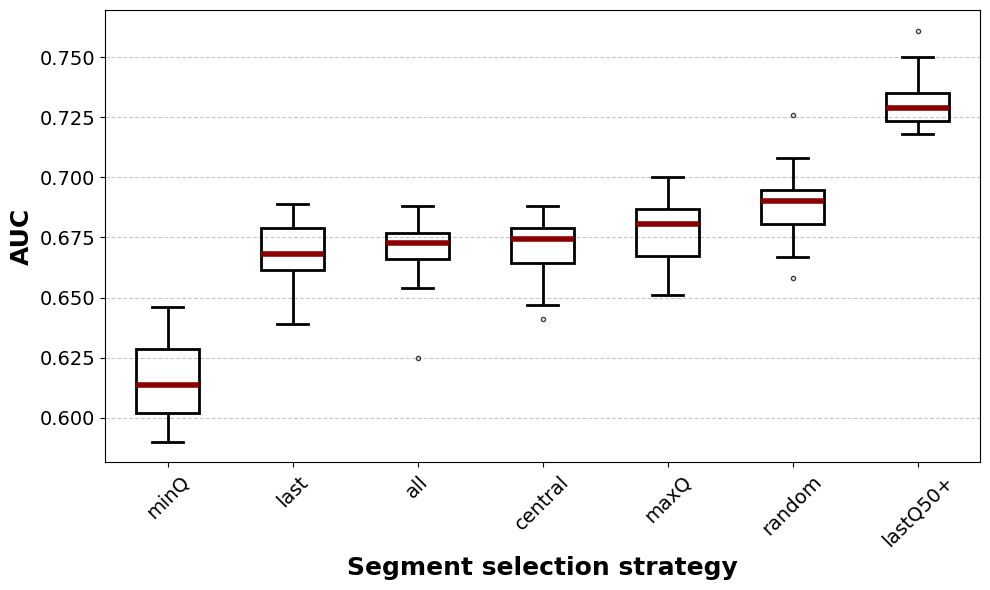

Estadístico de Kruskal-Wallis: 151.2819
Valor p: 4.1449e-30
Hay diferencias estadísticamente significativas entre al menos dos grupos.
Resultados del test de Dunn (p-values ajustados):


,all,central,last,lastQ50+,maxQ,minQ,random
all,1.000000e+00,1.000000e+00,1.000000e+00,3.906029e-10,1.000000e+00,5.182599e-05,8.269054e-03
central,1.000000e+00,1.000000e+00,1.000000e+00,1.930132e-09,1.000000e+00,1.577145e-05,1.978137e-02
last,1.000000e+00,1.000000e+00,1.000000e+00,2.499164e-11,9.761627e-01,3.263927e-04,1.753429e-03
lastQ50+,3.906029e-10,1.930132e-09,2.499164e-11,1.000000e+00,6.569564e-06,6.409247e-29,3.175078e-02
maxQ,1.000000e+00,1.000000e+00,9.761627e-01,6.569564e-06,1.000000e+00,5.790924e-09,1.000000e+00
minQ,5.182599e-05,1.577145e-05,3.263927e-04,6.409247e-29,5.790924e-09,1.000000e+00,3.190172e-15
random,8.269054e-03,1.978137e-02,1.753429e-03,3.175078e-02,1.000000e+00,3.190172e-15,1.000000e+00


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir a formato largo
df = pd.read_csv(os.path.join(DATA_FOLDER, "quality_strategies.csv"))
df_long = df.melt(var_name='estrategia', value_name='valor')

# Parámetros de estilo
THICK = 2
flierprops = dict(marker='o', markersize=3)
boxprops = dict(facecolor='none', edgecolor='black', linewidth=THICK)
whiskerprops = dict(color='black', linewidth=THICK)
capprops = dict(color='black', linewidth=THICK)
medianprops = dict(color='darkred', linewidth=THICK * 2)

# Graficar
plt.figure(figsize=(10, 6))

# Calcular la mediana por estrategia
orden = df_long.groupby('estrategia')['valor'].median().sort_values().index

sns.boxplot(data=df_long, x='estrategia', y='valor',
            order=orden,
            flierprops=flierprops,
            boxprops=boxprops,
            whiskerprops=whiskerprops,
            capprops=capprops,
            medianprops=medianprops,
            width=0.5)

# Etiquetas y formato
plt.xlabel("Segment selection strategy", fontsize=18)
plt.ylabel("AUC", fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("../img/boxplot_segment_selection.png", dpi=300, bbox_inches='tight')
plt.show()


from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

# Agrupar los valores por estrategia
grupos = [grupo['valor'].values for nombre, grupo in df_long.groupby('estrategia')]

# Aplicar el test de Kruskal-Wallis
stat, p = kruskal(*grupos)

# Mostrar resultados
print(f'Estadístico de Kruskal-Wallis: {stat:.4f}')
print(f'Valor p: {p:.4e}')

if p < 0.05:
    print("Hay diferencias estadísticamente significativas entre al menos dos grupos.")


dunn_result = posthoc_dunn(df_long, val_col='valor', group_col='estrategia', p_adjust='bonferroni')

# Mostrar la matriz de comparaciones
print("Resultados del test de Dunn (p-values ajustados):")
dunn_result


In [202]:
print(results["lastQ50+"])

[0.735, 0.735, 0.75, 0.722, 0.73, 0.727, 0.721, 0.743, 0.728, 0.74, 0.723, 0.729, 0.723, 0.72, 0.736, 0.721, 0.737, 0.726, 0.718, 0.729, 0.722, 0.725, 0.73, 0.735, 0.761, 0.727, 0.73, 0.733, 0.73, 0.727]


In [ ]:
# Perform Kruskal-Wallis H-test
groups = [plot_df[plot_df['Quality'] == quality]['Absolute Difference'].values for quality in plot_df['Quality'].unique()]
kruskal_result = kruskal(*groups)
print(kruskal_result)
# Perform Dunn's test for pairwise comparisons
dunn_result = posthoc_dunn(plot_df, val_col='Absolute Difference', group_col='Quality', p_adjust='bonferroni')
print(round(dunn_result, 3))

In [135]:
results

{'max': [0.681, 0.673, 0.697, 0.673, 0.644],
 'min': [0.614, 0.625, 0.593, 0.631, 0.602],
 'random': [0.696, 0.697, 0.686, 0.692, 0.692],
 'central': [0.688, 0.679, 0.678, 0.647, 0.662],
 'last': [0.661, 0.67, 0.685, 0.683, 0.684],
 'lastgood': [0.735, 0.735, 0.714, 0.713, 0.718],
 'all': [0.67, 0.657, 0.673, 0.67, 0.663]}

In [ ]:
# Define the sweep configuration
sweep_config = {
    "name": "FMM+Classical_PRUEBA",
    "method": "bayes",  # Bayesian optimization
    "metric": {"name": "roc_auc", "goal": "maximize"},
    "parameters": {
        "n_estimators": {"values": [25, 50, 100, 150, 200]},
        "max_depth": {"min": 2, "max": 10},
        "max_features": {"min": 5, "max": 50},
        "min_samples_split": {"min": 2, "max": 10},
        "min_samples_leaf": {"min": 1, "max": 5},
    },
}

sweep_config = {
    "name": "FMM+Classical_PRUEBA",
    "method": "bayes",  # Bayesian optimization
    "metric": {"name": "roc_auc", "goal": "maximize"},
    "parameters": {
        "n_estimators": {"min": 100, "max": 600},
        "max_depth": {"min": 2, "max": 10},
        "max_features": {"min": 3, "max": 100},
        "min_samples_split": {"min": 2, "max": 10},
        "min_samples_leaf": {"min": 1, "max": 20},
    },
}


# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="UM-MScAI-Thesis2025")


# Define the training function
def train():
    # Initialize a new W&B run
    with wandb.init() as run:
        # Get hyperparameters from W&B
        config = wandb.config

        # Update the classifier with the current hyperparameters
        pipeline.set_params(
            classifier__n_estimators=config.n_estimators,
            classifier__max_depth=config.max_depth,
            classifier__min_samples_split=config.min_samples_split,
            classifier__min_samples_leaf=config.min_samples_leaf,
        )

        # Perform cross-validation and compute scores directly
        scores = cross_val_score(pipeline, X, y, groups=groups, cv=group_kfold)
        avg_score = np.mean(scores)
        wandb.log({"roc_auc": avg_score})


# Run the sweep
wandb.agent(sweep_id, train, count=10000)